# Test Gaze Prediction Model
This notebook loads and tests the trained gaze prediction model on sample images.

In [1]:
# Import required libraries
import torch
import torch.nn as nn
from torchvision import transforms, models
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import random
import os

# Set random seed for reproducibility
random.seed(42)
torch.manual_seed(42)

In [2]:
# Define the model architecture (copy from CNN_face.py)
class GazeResNet(nn.Module):
    def __init__(self, pretrained=True):
        super(GazeResNet, self).__init__()
        # Use ResNet34 as base
        self.resnet = models.resnet34(pretrained=pretrained)

        # Replace the last fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.resnet(x)

In [6]:
# Load the trained model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
model = GazeResNet(pretrained=False).to(device)

# Load the saved model state
checkpoint = torch.load('best_gaze_model.pth', map_location=torch.device('cpu'))
#model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Load the dataset
df = pd.read_csv(r'C:\\Users\\orlan\\OneDrive\\Desktop\\2semestre\\AI COMPUTER VISION\\code\\project\\eye_traking\\data_collection_phase\\data\\only_face.csv')

# Get min/max values for denormalization
x_min = df['x'].min()
x_max = df['x'].max()
y_min = df['y'].min()
y_max = df['y'].max()

print(f"Screen coordinates range: X({x_min:.0f}, {x_max:.0f}), Y({y_min:.0f}, {y_max:.0f})")

Using device: cpu
Screen coordinates range: X(0, 1919), Y(0, 1079)


In [11]:
# Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

def predict_gaze(image_path):
    """Predict gaze coordinates from an image"""
    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Get prediction
    with torch.no_grad():
        pred = model(image_tensor).cpu().numpy()[0]

    # Denormalize predictions
    pred_x = pred[0] * (x_max - x_min) + x_min
    pred_y = pred[1] * (y_max - y_min) + y_min

    return pred_x, pred_y

In [12]:
def visualize_prediction(image_path, actual_x, actual_y, pred_x, pred_y):
    #\"\"\"Visualize the prediction results\"\"\"\n",
    # Create a black image representing the screen (1920x1080)
    screen = np.zeros((1080, 1920, 3), dtype=np.uint8)

    # Draw actual point (green)
    cv2.circle(screen, (int(actual_x), int(actual_y)), 15, (0, 255, 0), -1)
    cv2.circle(screen, (int(actual_x), int(actual_y)), 17, (255, 255, 255), 2)

    # Draw predicted point (red)
    cv2.circle(screen, (int(pred_x), int(pred_y)), 15, (0, 0, 255), -1)
    cv2.circle(screen, (int(pred_x), int(pred_y)), 17, (255, 255, 255), 2)

    # Draw line between points\n",
    cv2.line(screen, (int(actual_x), int(actual_y)), (int(pred_x), int(pred_y)), (255, 255, 255), 2)

    # Load and resize the face image for display
    face = cv2.imread(image_path)
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)

    # Create the figure
    plt.figure(figsize=(20, 8))

    # Plot the screen
    plt.subplot(1, 2, 1)
    plt.imshow(screen)
    plt.title('Screen View (1920x1080)\\nGreen: Actual Point, Red: Predicted Point', fontsize=12)
    plt.axis('off')

    # Plot the face
    plt.subplot(1, 2, 2)
    plt.imshow(face)
    plt.title('Input Face Image', fontsize=12)
    plt.axis('off')

    # Calculate error
    error = np.sqrt((actual_x - pred_x)**2 + (actual_y - pred_y)**2)
    plt.suptitle(f'Prediction Error: {error:.0f} pixels', fontsize=14)

    plt.tight_layout()
    plt.show()

Testing on 10 random samples...
Sample 1468:
Actual point: (670, 488)
Predicted point: (647, 686)
Error: 199 pixels
--------------------------------------------------


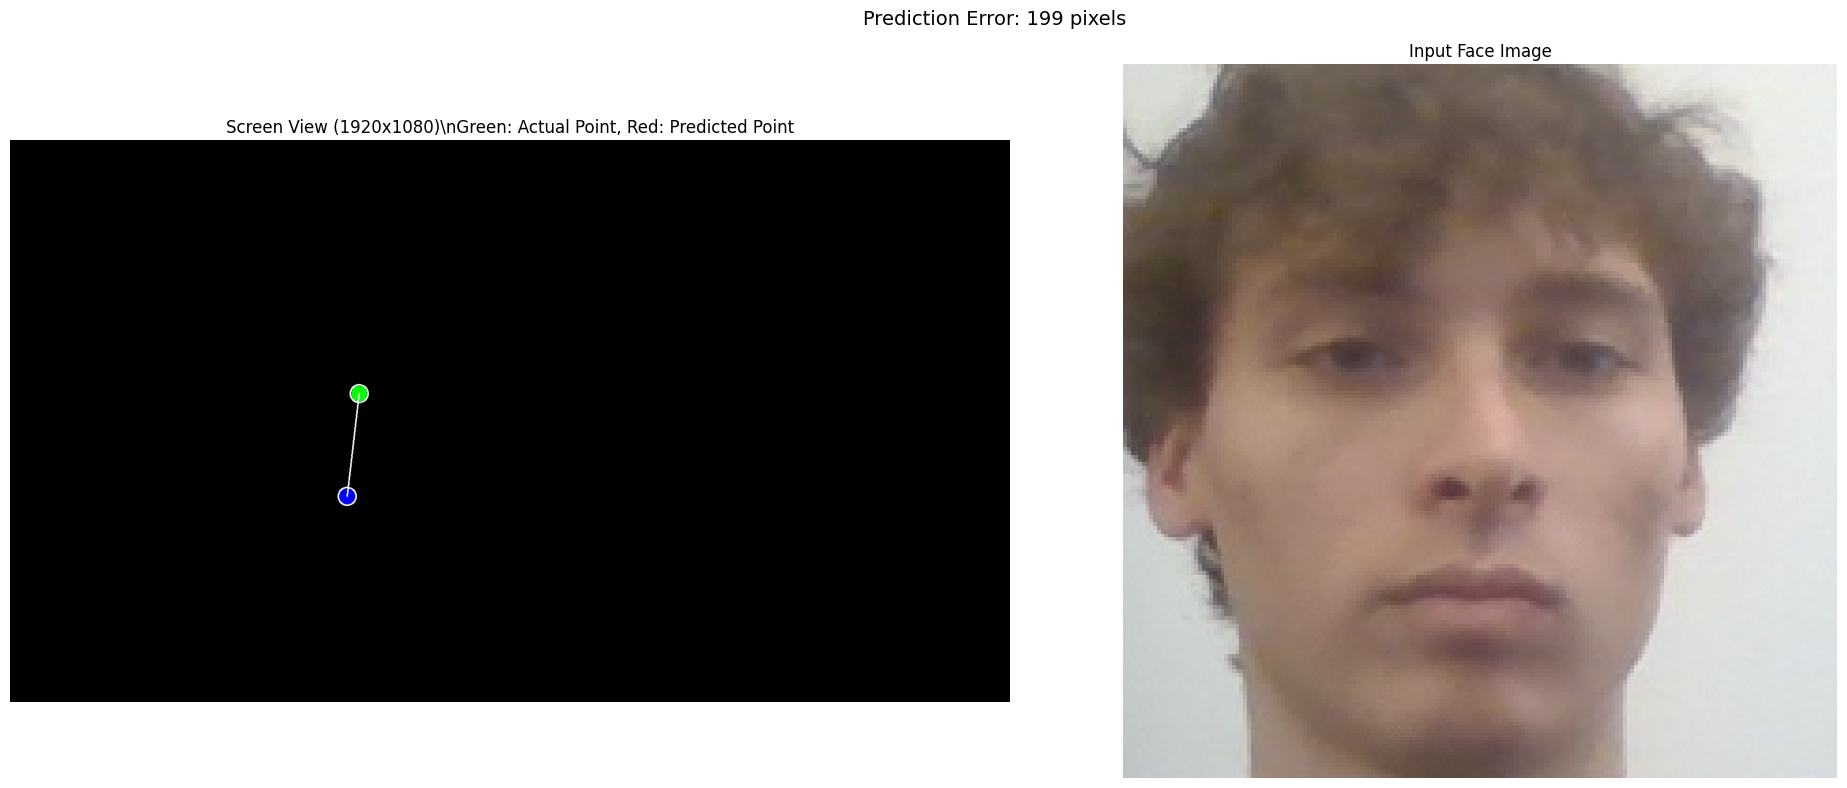

Sample 2693:
Actual point: (1145, 222)
Predicted point: (630, 676)
Error: 686 pixels
--------------------------------------------------


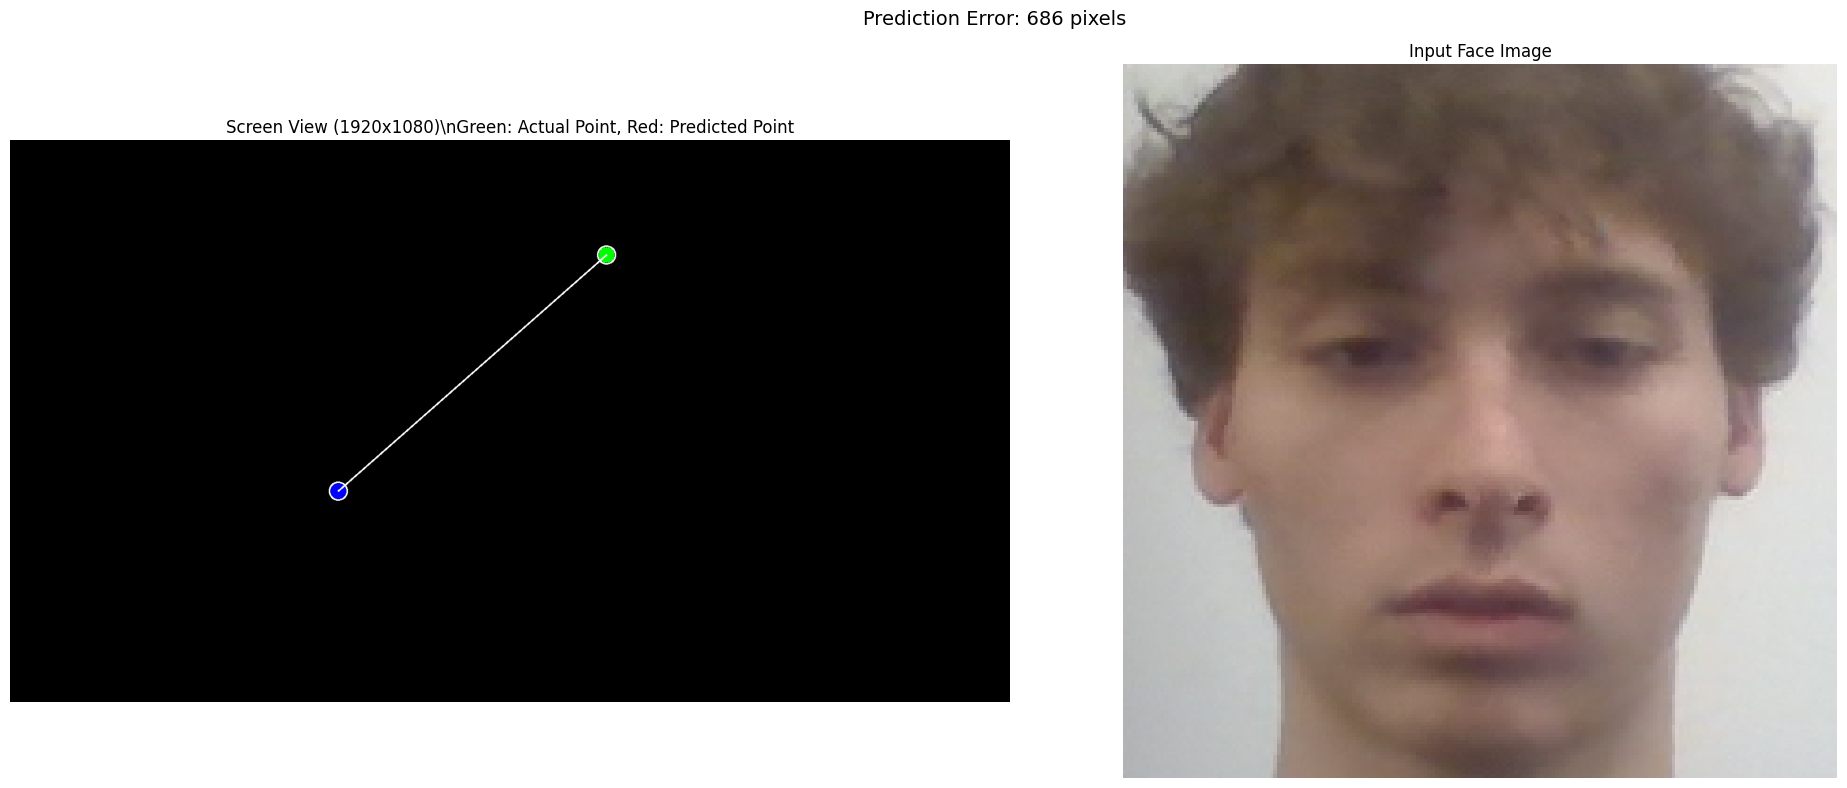

Sample 2017:
Actual point: (1552, 846)
Predicted point: (621, 669)
Error: 947 pixels
--------------------------------------------------


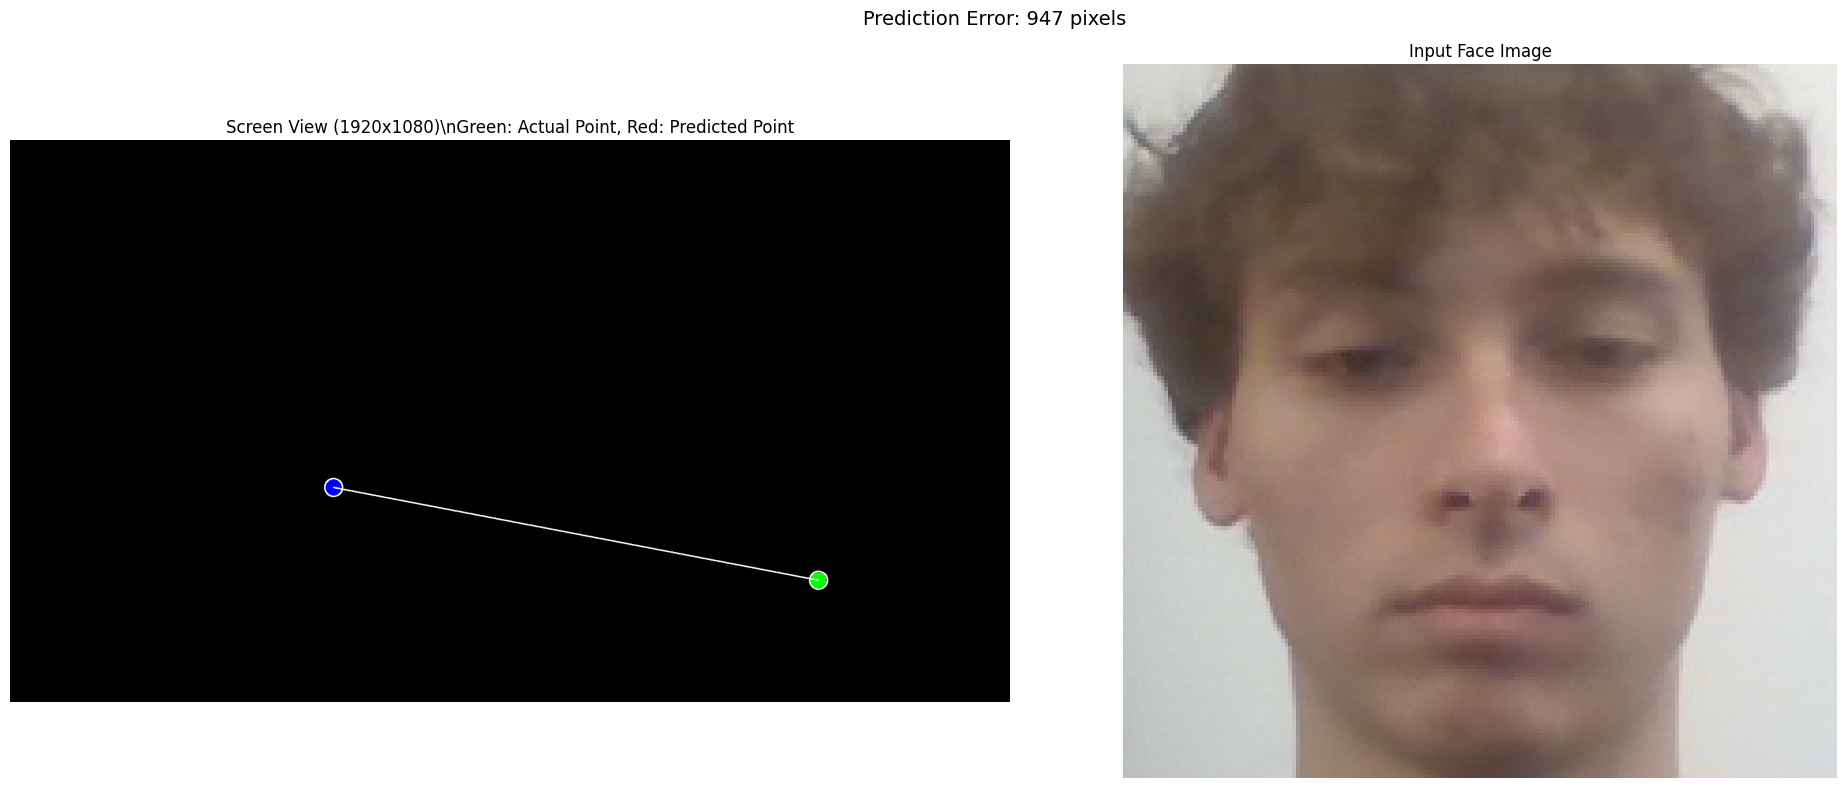

Sample 2646:
Actual point: (1488, 169)
Predicted point: (637, 670)
Error: 987 pixels
--------------------------------------------------


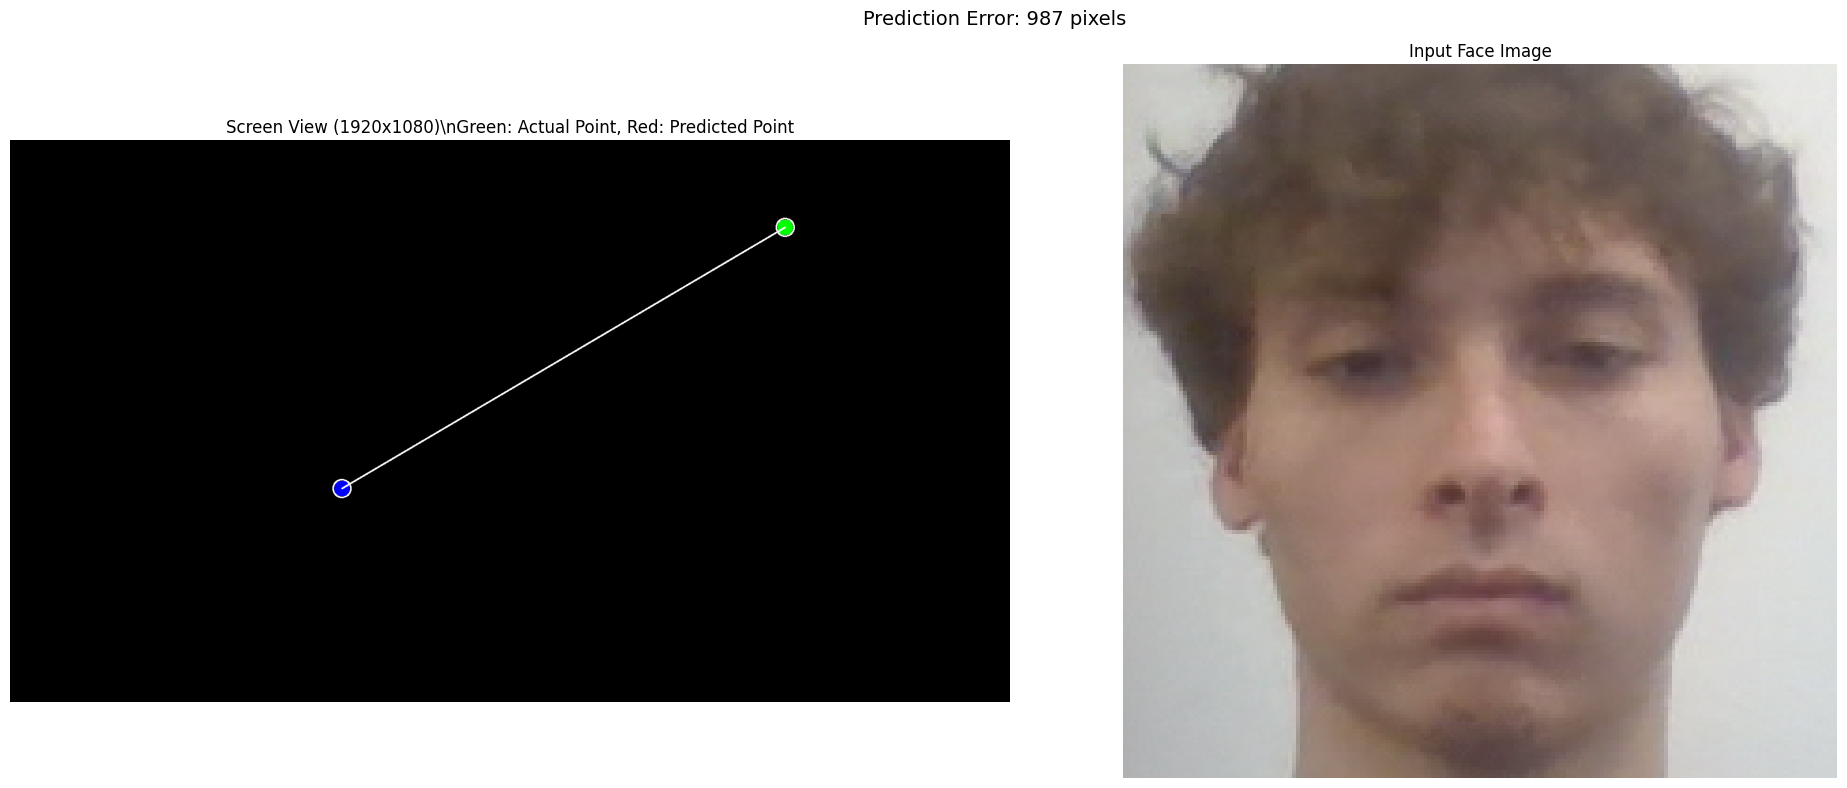

Sample 1429:
Actual point: (1031, 218)
Predicted point: (633, 665)
Error: 599 pixels
--------------------------------------------------


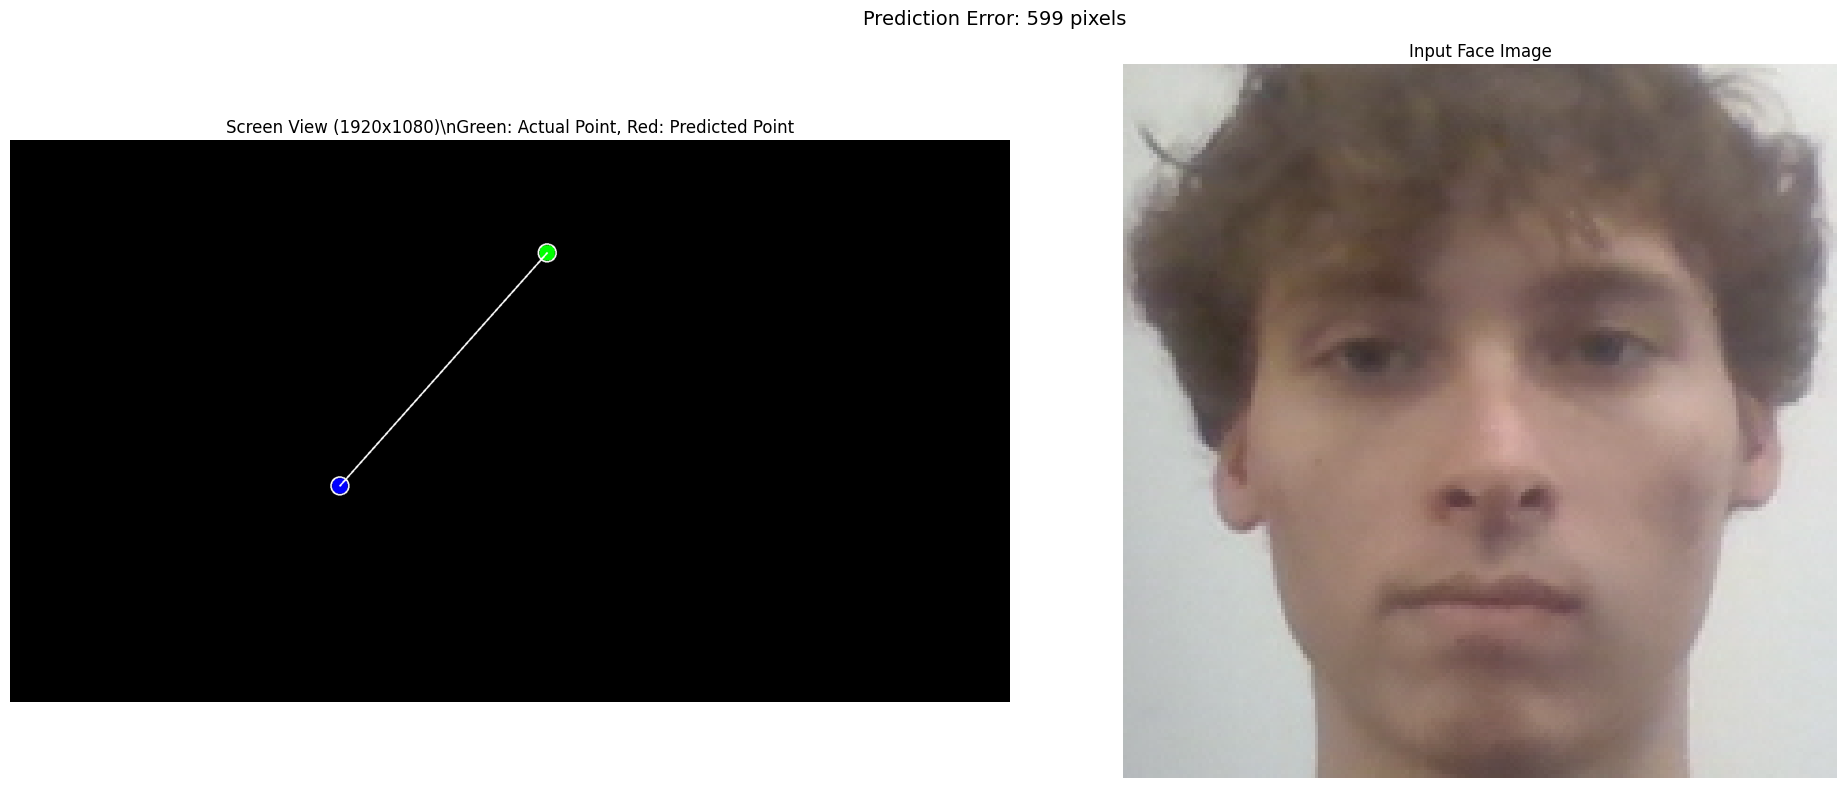

Sample 2950:
Actual point: (678, 1064)
Predicted point: (635, 668)
Error: 399 pixels
--------------------------------------------------


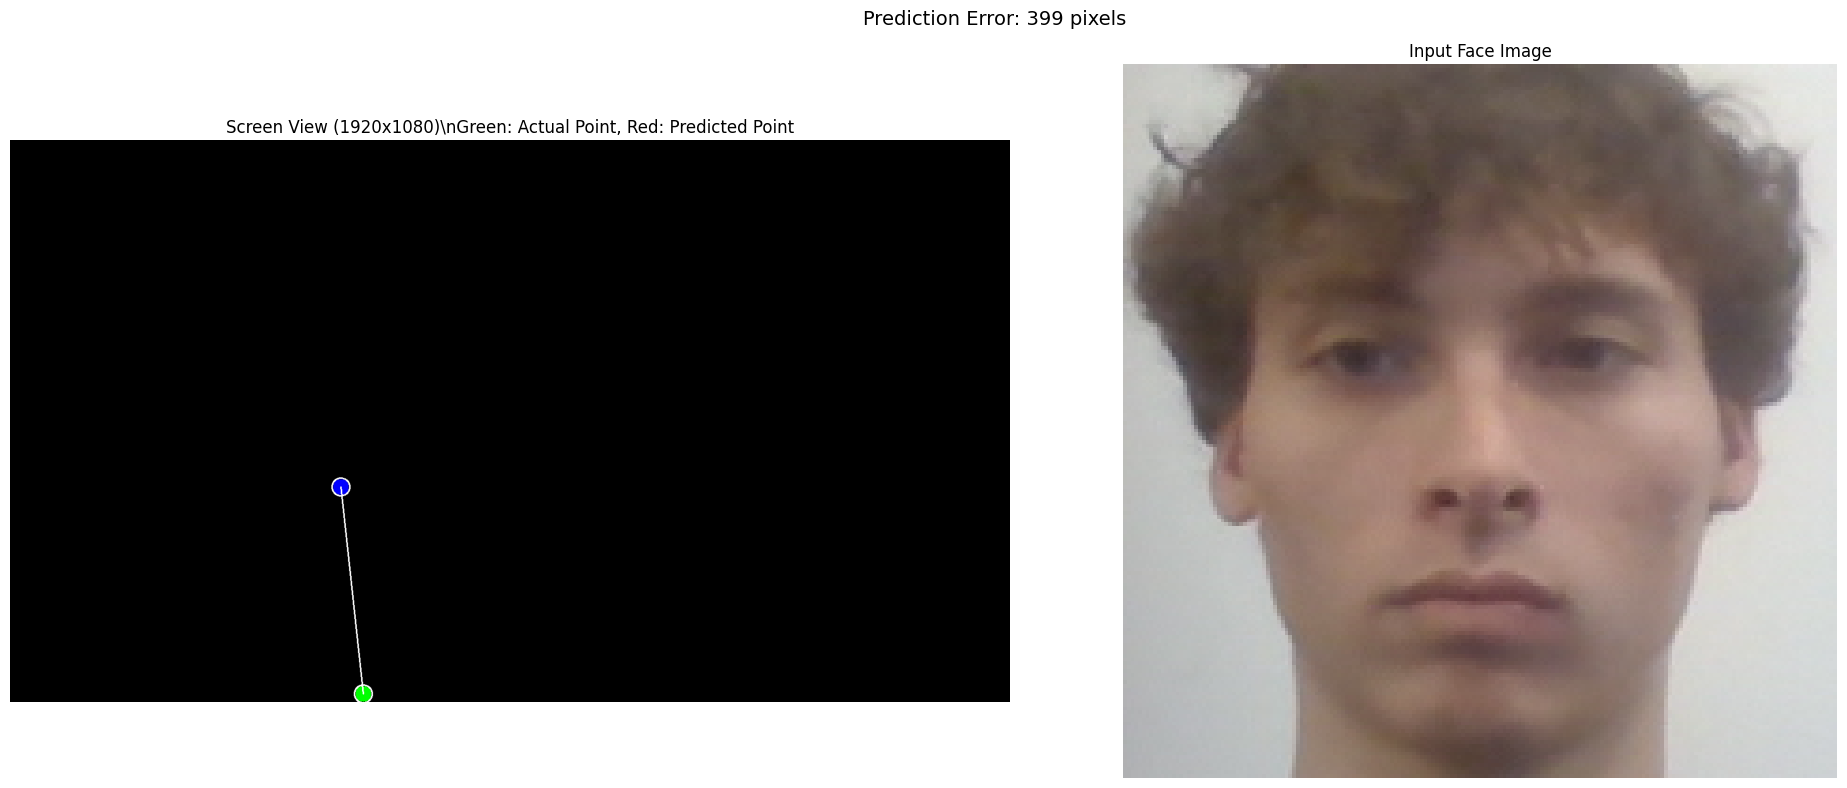

Sample 59:
Actual point: (1312, 728)
Predicted point: (651, 668)
Error: 664 pixels
--------------------------------------------------


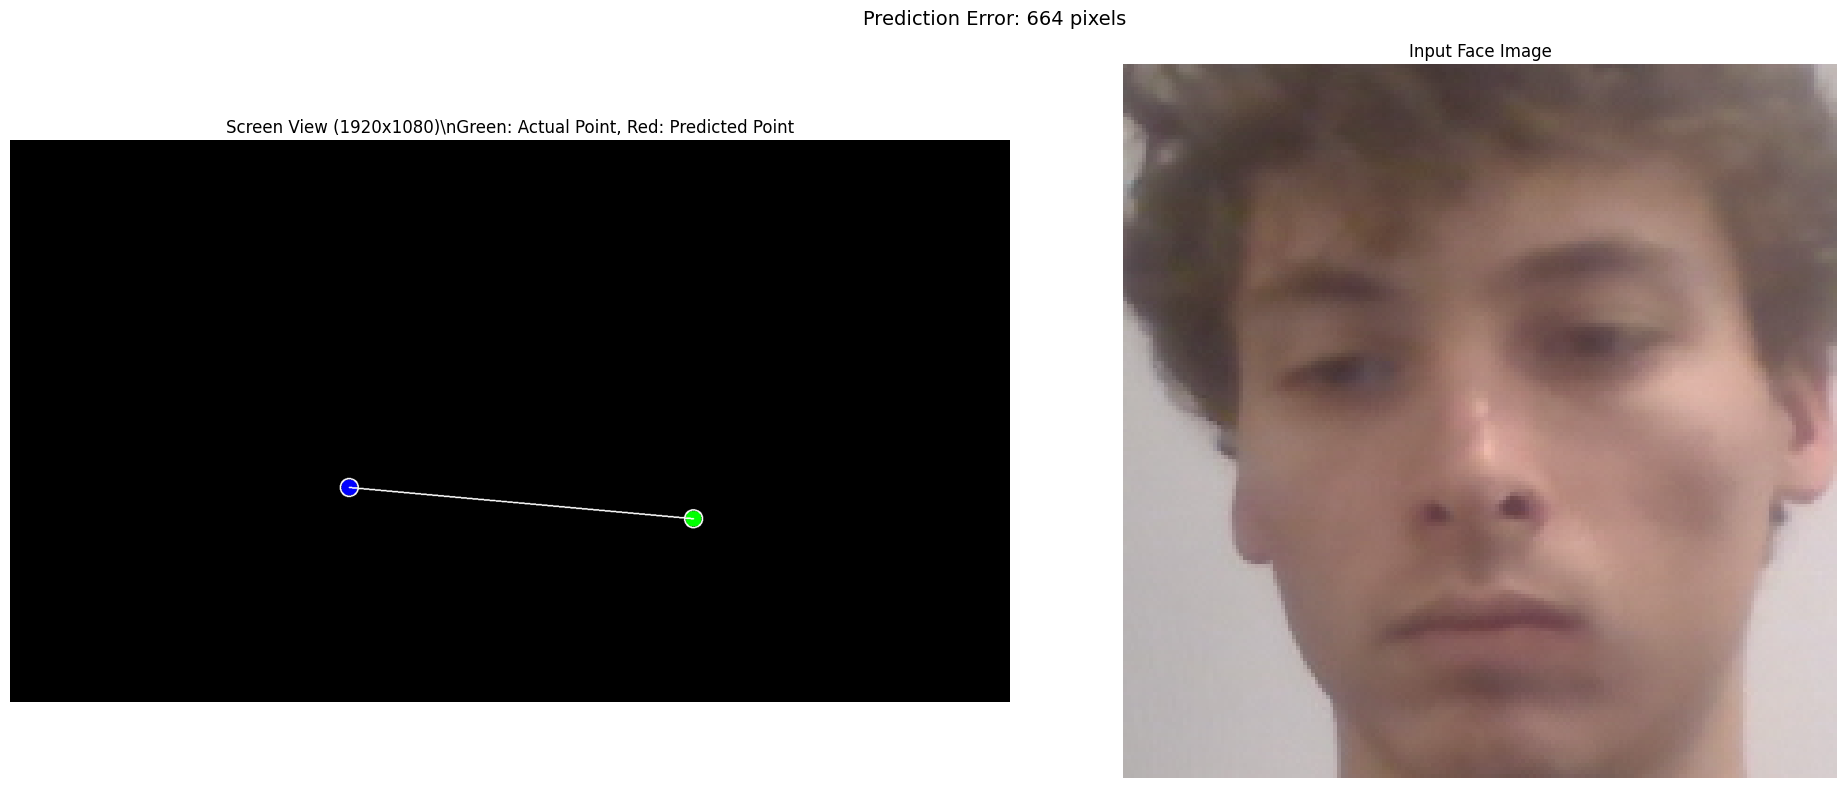

Sample 2408:
Actual point: (774, 644)
Predicted point: (641, 661)
Error: 135 pixels
--------------------------------------------------


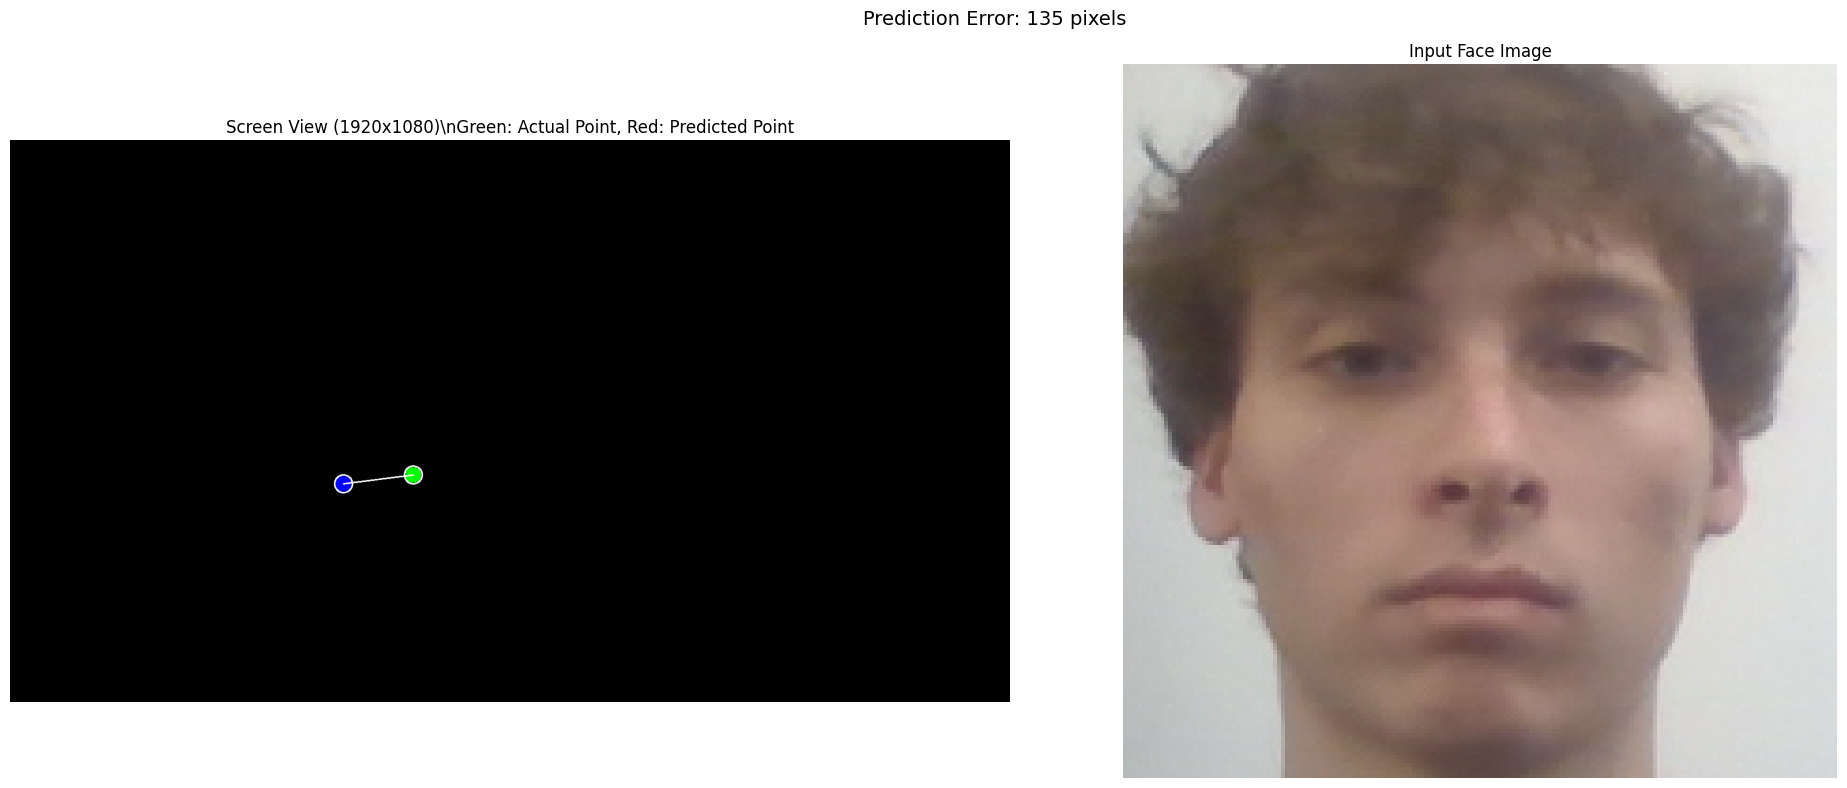

Sample 745:
Actual point: (443, 550)
Predicted point: (657, 674)
Error: 248 pixels
--------------------------------------------------


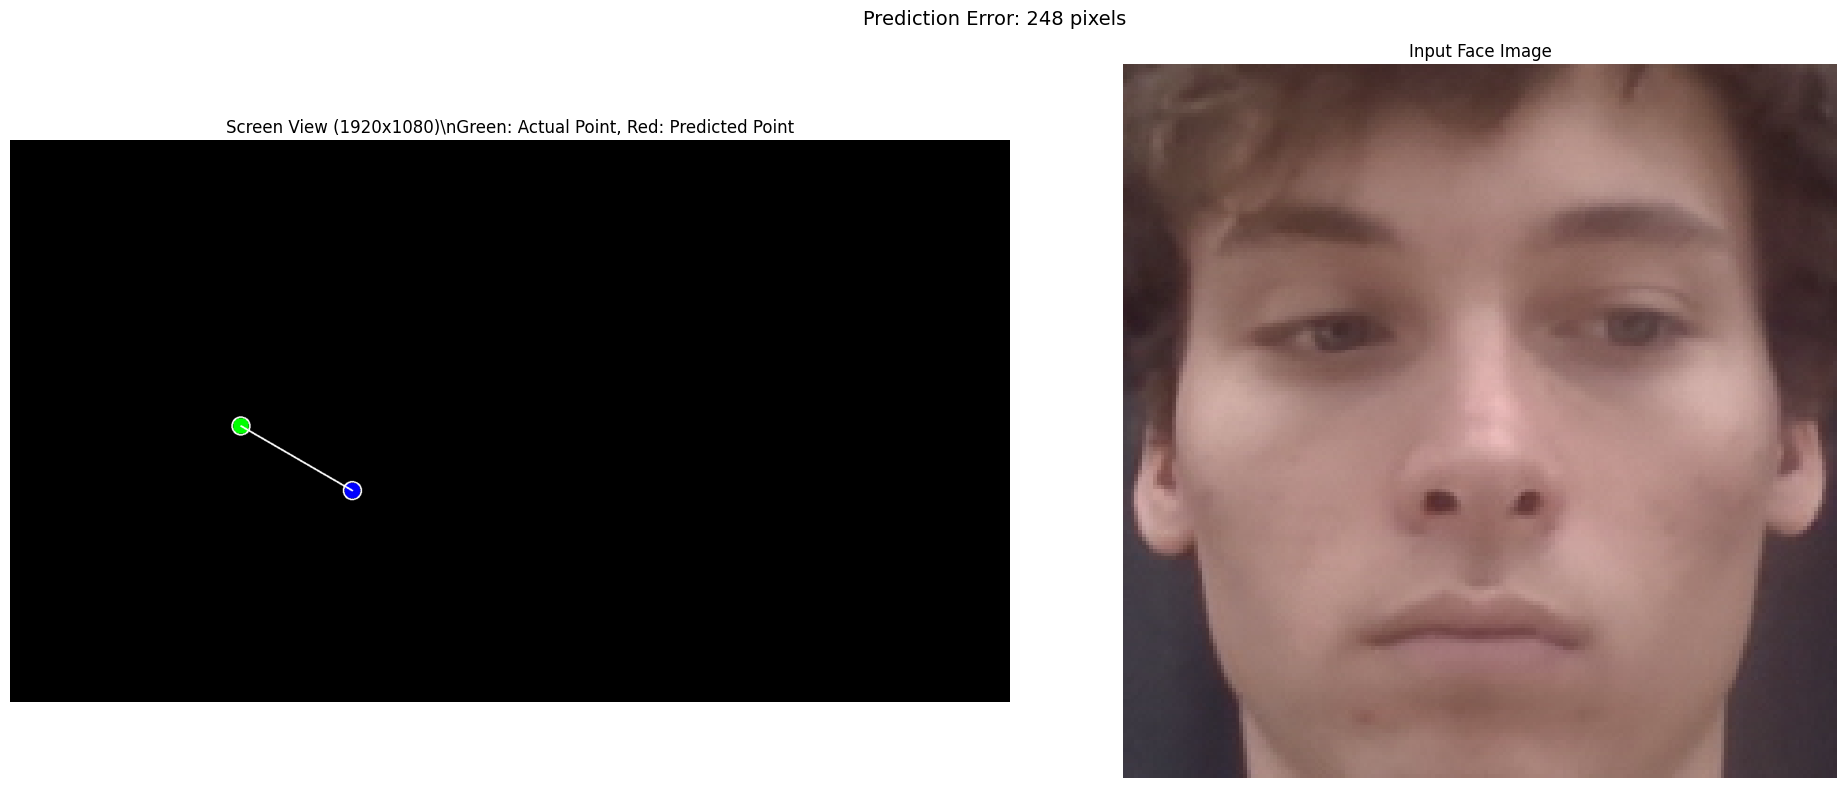

Sample 1977:
Actual point: (379, 463)
Predicted point: (640, 671)
Error: 334 pixels
--------------------------------------------------


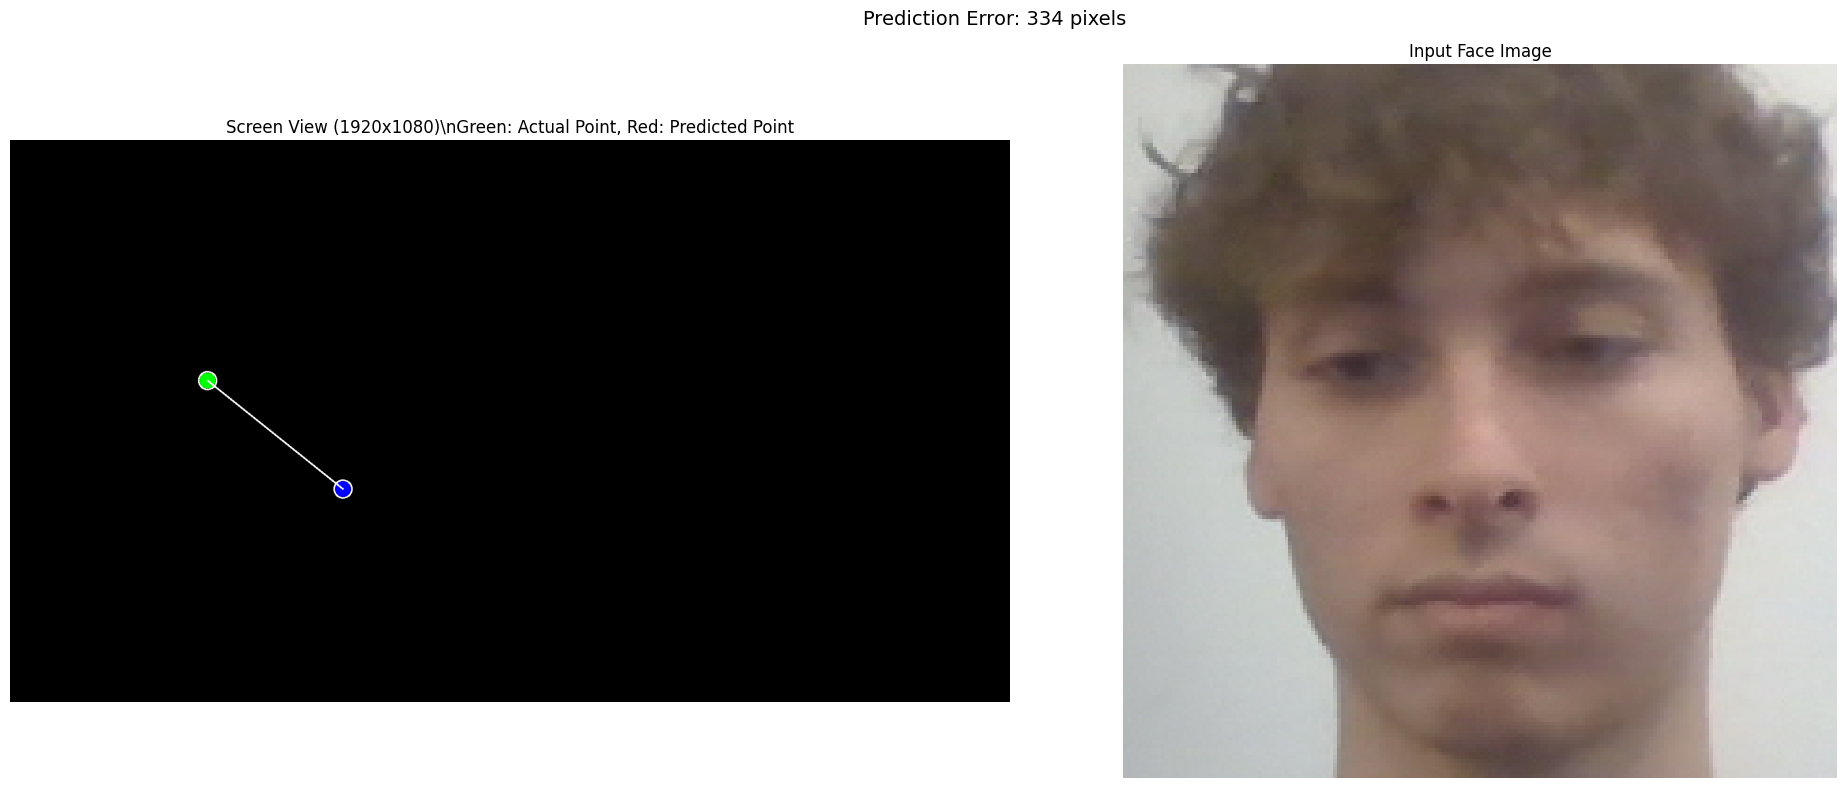

In [13]:
# Test on 10 random samples
print("Testing on 10 random samples...")

# Select 10 random samples from the dataset
test_samples = df.sample(n=10)

# Test and visualize each sample
for idx, row in test_samples.iterrows():
    print(f"Sample {idx}:")

    # Get image path
    image_path = os.path.join(
        r'C:\\Users\\orlan\\OneDrive\\Desktop\\2semestre\\AI COMPUTER VISION\\code\\project\\eye_traking\\data_collection_phase\\data\\only_face',
        os.path.basename(row['File Path Face Image'])
    )

    # Get actual coordinates
    actual_x = row['x']
    actual_y = row['y']

    # Get predicted coordinates
    pred_x, pred_y = predict_gaze(image_path)

    # Calculate error
    error = np.sqrt((actual_x - pred_x)**2 + (actual_y - pred_y)**2)

    # Print results
    print(f"Actual point: ({actual_x:.0f}, {actual_y:.0f})")
    print(f"Predicted point: ({pred_x:.0f}, {pred_y:.0f})")
    print(f"Error: {error:.0f} pixels")
    print("-" * 50)

    # Visualize the results
    visualize_prediction(image_path, actual_x, actual_y, pred_x, pred_y)

<>:29: SyntaxWarning: invalid escape sequence '\+'
<>:29: SyntaxWarning: invalid escape sequence '\+'
C:\Users\orlan\AppData\Local\Temp\ipykernel_22724\1955034626.py:29: SyntaxWarning: invalid escape sequence '\+'
  print(f"Standard Deviation: {np.std(all_errors):.0f} pixels\+")


Calculating statistics on 100 random samples...
Model Performance Statistics:
Average Error: 708 pixels
Median Error: 672 pixels
Standard Deviation: 315 pixels\+
Min Error: 68 pixels
Max Error: 1310 pixels


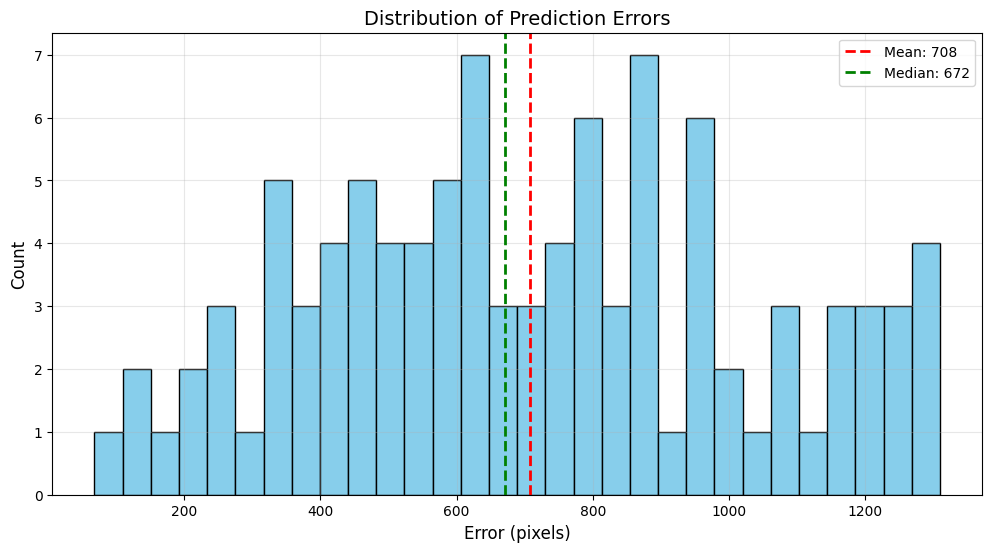

In [14]:
# Calculate statistics on more samples
print("Calculating statistics on 100 random samples...")

all_errors = []
all_actual = []
all_predicted = []

# Test on 100 random samples for better statistics
test_samples_stats = df.sample(n=100)

for _, row in test_samples_stats.iterrows():
    image_path = os.path.join(
        r'C:\\Users\\orlan\\OneDrive\\Desktop\\2semestre\\AI COMPUTER VISION\\code\\project\\eye_traking\\data_collection_phase\\data\\only_face',
        os.path.basename(row['File Path Face Image'])
    )

    actual_x, actual_y = row['x'], row['y']
    pred_x, pred_y = predict_gaze(image_path)

    error = np.sqrt((actual_x - pred_x)**2 + (actual_y - pred_y)**2)
    all_errors.append(error)
    all_actual.append((actual_x, actual_y))
    all_predicted.append((pred_x, pred_y))

# Print statistics
print("Model Performance Statistics:")
print(f"Average Error: {np.mean(all_errors):.0f} pixels")
print(f"Median Error: {np.median(all_errors):.0f} pixels")
print(f"Standard Deviation: {np.std(all_errors):.0f} pixels\+")
print(f"Min Error: {np.min(all_errors):.0f} pixels")
print(f"Max Error: {np.max(all_errors):.0f} pixels")

# Plot error distribution
plt.figure(figsize=(12, 6))
plt.hist(all_errors, bins=30, color='skyblue', edgecolor='black')
plt.axvline(np.mean(all_errors), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(all_errors):.0f}')
plt.axvline(np.median(all_errors), color='green', linestyle='dashed', linewidth=2, label=f'Median: {np.median(all_errors):.0f}')
plt.title('Distribution of Prediction Errors', fontsize=14)
plt.xlabel('Error (pixels)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

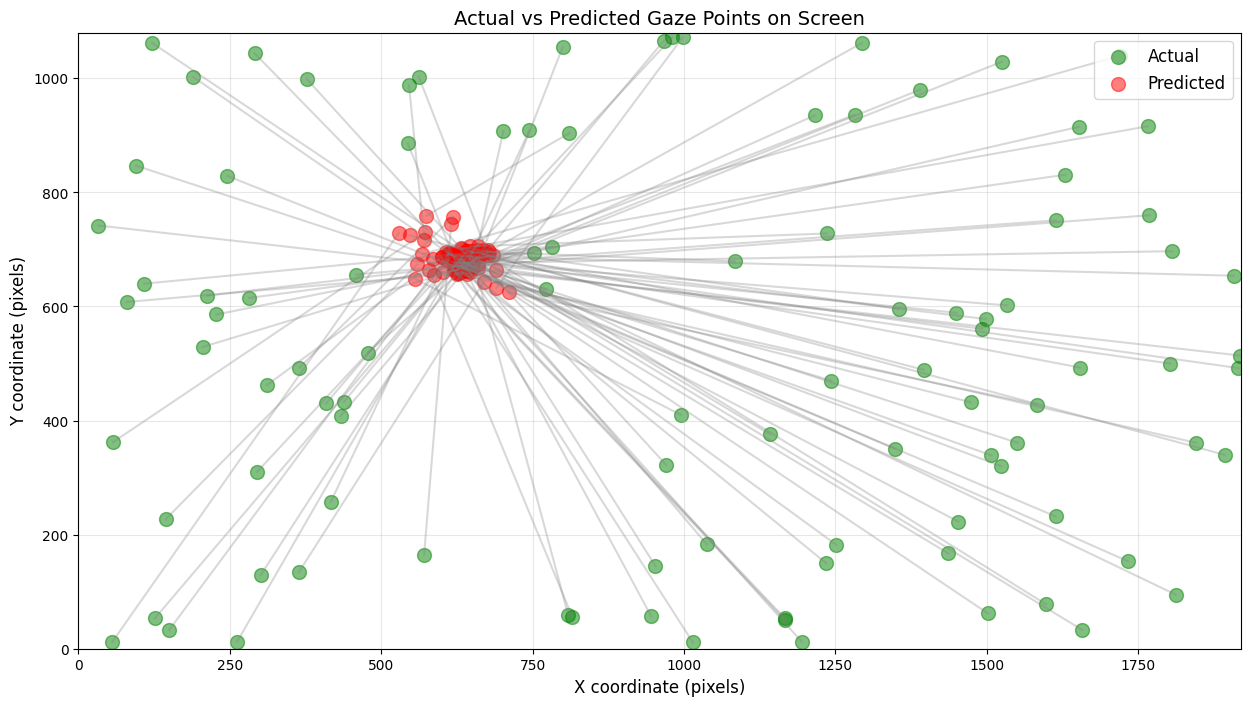

In [15]:
# Visualize prediction heatmap
plt.figure(figsize=(15, 8))

# Plot actual points
actual_x = [p[0] for p in all_actual]
actual_y = [p[1] for p in all_actual]
plt.scatter(actual_x, actual_y, c='green', alpha=0.5, label='Actual', s=100)

# Plot predicted points
pred_x = [p[0] for p in all_predicted]
pred_y = [p[1] for p in all_predicted]
plt.scatter(pred_x, pred_y, c='red', alpha=0.5, label='Predicted', s=100)

# Draw lines between actual and predicted points
for (ax, ay), (px, py) in zip(all_actual, all_predicted):
    plt.plot([ax, px], [ay, py], 'gray', alpha=0.3)

plt.title('Actual vs Predicted Gaze Points on Screen', fontsize=14)
plt.xlabel('X coordinate (pixels)', fontsize=12)
plt.ylabel('Y coordinate (pixels)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Set axis limits to match screen resolution
plt.xlim(0, 1920)
plt.ylim(0, 1080)

plt.show()